This is a simulation of Covid-19 spread in the Netherlands around Schiphol airport. It simulates arriving flights with (a few) infected residents arriving at Schiphol airport and then returning home, where they proceed to infect others. This simulation is *not* based on pre-existing epidemiological models such as SIR. Instead, it has been built up from first principles, and a whole bunch of simplifying assumptions.

An interesting feature of this simulation is that it incorporates geography: it uses population data for neighbourhoods in the Netherlands and their geographic coordinates in order to model the spread of the virus. In its current form, it is admittedly quite limited: an infected person can only infect others within the same neighbourhood. However, it should already allow for some appealing visuals (coming in a future post). Next to visuals, I would like to see if we can learn something about the effectiveness of **restricting all air travel** and **social distancing**. 

Disclaimer:  The assumptions I made do not do justice to the complexity of the situation. I am not an epidemiologist, this is not policy advice, and all opinions mentioned below are my own.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Optional, Dict
import pickle

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from geographiclib.geodesic import Geodesic

from lib.state import PersonState
from lib.results import SimulationResult, SimulationResultStorage
%matplotlib inline

### Simplifying assumptions
Let's start by listing all the ways the simulation is incorrect:

- Nobody who is currently in the country is sick on the beginning of day 0.
- Infected residents arrive only by aircraft, starting from day 0.
- The fraction of the population returning per day is crudely estimated to be 0.001 using Schiphol's flight data for February 2020  (encoded in `fraction_of_populace_returning_per_day`) <1>.
- The fraction of those residents being infected is assumed to be to 0.01 (encoded in `fraction_returning_travelers_infected`). This remains fixed throughout the timeline (until travel restrictions come into effect: then it drops to 0).
- The population of The Netherlands is reduced to contain only neighbourhoods in close proximity to the airport (encoded in `max_distance_from_airport_km`).
- Arriving residents are randomly chosen out of the entire (nearby) population (uniformly). This determines where they live, and therefore where they will proceed to spread the virus.
- People will only infect others within their own neighbourhood <2>.
- Incubation period is 5 days (encoded in `incubation_period_days`) <3>.
- People are sick and contagious for 14 days (encoded in `days_sick`).
- Each person will infect 2.5 others on average as long as no measures are put in place (encoded in `avg_num_others_infected`). 
- Social distancing assumes a reduction of 40% to 1.5 (encoded in `avg_num_others_infected_with_social_distancing`) <4>.
- People will be immune after having been sick (if they survived).
- 97.5% probability of surviving (encoded in `prob_survive`) <5>.

<1>: The fraction of the populace returning per day was estimated by counting the number of non-transfer arriving passengers, after accounting for *assumed* tourism numbers (50 %), hidden transfers (separately booked flights; 10 %) and repeat business travel (10 %). This leaves 16.000 residents returning every day, or about 0.1 % of the entire population.

<2>: Only being able to infect others in the same neighbourhood is probably too restrictive and could be changed to either the entire municipality or a radius in a future version.

<3>: Source for incubation period: [The Incubation Period of Coronavirus Disease 2019 (COVID-19) From Publicly Reported Confirmed Cases: Estimation and Application by Stephen A. Lauer et al.](https://annals.org/aim/fullarticle/2762808/incubation-period-coronavirus-disease-2019-covid-19-from-publicly-reported).

<4>: 1.5 is probably still on the high side; reports from the Dutch RIVM indicate that it dropped to 1 or lower in late March.

<5>: This is a drastic oversimplification of survival rate: it should be conditioned on the available capacity in hospitals. We've seen that survival rate drops as hospitals reach capacity. Hence, please don't take my casualty numbers too seriously.

In [3]:
fraction_of_populace_returning_per_day = 0.001 
fraction_returning_travelers_infected = .01

max_distance_from_airport_km = 30

incubation_period_days = 5
days_sick = 14

avg_num_others_infected = 2.5
avg_num_others_infected_with_social_distancing = 1.5

prob_survive = 0.975

airport_location_lon = 4.764167
airport_location_lat = 52.308056

### Prepare population
The population data comes from CBS (Statistics Netherlands) and is loaded using `geopandas`.
Here, we immediately make a selection to reduce the dataset to a more manageable set, based on proximity to the airport.

In [4]:
dfp = (
    gpd
    .read_file("./data/transformed/population.shp")
    .assign(centroid=lambda df: df["geometry"].map(lambda x: x.centroid))
    .drop("geometry", axis=1)
    .assign(
        airport_distance_km=
        lambda df: df["centroid"].map(
            lambda c: Geodesic.WGS84.Inverse(
                airport_location_lat, airport_location_lon, 
                c.y, c.x)["s12"] / 1000
        )
    )
)
len_dfp_all = len(dfp)
total_population = dfp["pop"].sum()

dfp = dfp[dfp["airport_distance_km"] < max_distance_from_airport_km]
dfp.index.name = "hood_id"
selected_population = dfp["pop"].sum()
print(f"{len_dfp_all} neighbourhoods in total "
      f"({total_population=}),\n"
      f"{len(dfp)} left after restricting on proximity "
      f"to airport ({selected_population=}).")
pd.concat((dfp.head(), dfp.tail()))

2794 neighbourhoods in total (total_population=16891285),
287 left after restricting on proximity to airport (selected_population=2798085).


,hood,muni,pop,centroid,airport_distance_km
hood_id,,,,,
85,Wijk 00 Aalsmeer,Aalsmeer,12030,POINT (4.73681 52.25318),6.384820
86,Wijk 01 Kudelstraat en Kalslagen,Aalsmeer,9200,POINT (4.73985 52.23702),8.076712
87,Wijk 02 Oosteinde,Aalsmeer,9840,POINT (4.79539 52.28221),3.579371
110,Graft-De Rijp,Alkmaar,6400,POINT (4.81444 52.55156),27.310634
132,Wijk 04 Almere Poort,Almere,9480,POINT (5.15331 52.34850),26.908871
2704,Zandvoort Noord,Zandvoort,7570,POINT (4.54313 52.38240),17.185225
2705,Zandvoort Zuid,Zandvoort,8140,POINT (4.53755 52.36961),16.896112
2717,Wijk 04 Kwadijk,Zeevang,785,POINT (4.98505 52.53218),29.116661
2740,Wijk 00 Zoeterwoude,Zoeterwoude,5565,POINT (4.51166 52.11195),27.822176


The top 10 largest municipalities by population count:

In [5]:
dfp.groupby("muni")["pop"].sum().sort_values(ascending=False).head(10)

muni
Amsterdam              821705
Haarlem                156625
Zaanstad               151375
Haarlemmermeer         144060
Leiden                 121525
Alphen aan den Rijn    107360
Amstelveen              87160
Purmerend               79600
Velsen                  67100
Stichtse Vecht          63965
Name: pop, dtype: int64

### Build a DataFrame with a row for each person.
We are going to maintain state for each person. In particular, we need to keep track of their current "state", the date at which they were infected, and where they live.

In [6]:
def build_population_df_func(dfp: pd.DataFrame) -> pd.DataFrame:
    """Builds a DataFrame for the population where everyone is  
    still 'untouched' by the virus.
    """
    pop_hood_ids = []
    for hood_id, row in dfp.iterrows():
        pop_hood_ids.extend([hood_id] * row["pop"])
    assert len(pop_hood_ids) == selected_population
    
    def create_df():
        return pd.DataFrame({
            "person_id": range(selected_population),
            "infection_day": pd.NA,
            "state": PersonState.untouched,
            "hood_id": pop_hood_ids
        }).set_index("person_id") 
    return create_df

In [7]:
build_population_df = build_population_df_func(dfp)

In [8]:
pop = build_population_df()
pd.concat((pop.head(2), pop.tail(2)))

,infection_day,state,hood_id
person_id,,,
0,<NA>,PersonState.untouched,85
1,<NA>,PersonState.untouched,85
2798083,<NA>,PersonState.untouched,2741
2798084,<NA>,PersonState.untouched,2741


# Simulation

This simulation is built naively and is not fast at all due to using Pandas in ways it's not really designed for (`itertuples`, a lot of setting with `loc`) - but it works as long as the dataset remains small. The upside to this is that the code remains reasonably simple and easy to follow.

In [9]:
def simulate_spread(day: int, 
                    pop: pd.DataFrame,
                    prob_infect_daily: float, 
                    prob_infect_daily_with_social_distancing: float,
                    social_distancing_day: Optional[int] = None
                   ) -> pd.DataFrame:
    """Simulate the spreading of the virus within the population."""
    if isinstance(social_distancing_day, int) \
            and day >= social_distancing_day:
        # Social Distancing is in place!
        effective_prob_inf_daily = prob_infect_daily_with_social_distancing
    else:
        effective_prob_inf_daily = prob_infect_daily
    
    pop_contagious = (
        pop[(pop["state"] == PersonState.infected) &
            (pop["infection_day"] + incubation_period_days <= day)]
        .assign(infect_other=lambda df: 
                np.random.random(size=len(df)) < effective_prob_inf_daily)
        .query("infect_other == True")
    )
    pop_contagious_per_hood = pop_contagious.groupby("hood_id").sum()
    
    for hood_id, num_to_infect in pop_contagious_per_hood.itertuples():
        # Let's see who they spread the virus to. Only "untouched" will
        # actually be infected, the others already are or are immune.
        pop_to_spread_to = pop[
            (pop["hood_id"] == hood_id) &
            (pop["state"].isin({PersonState.untouched, 
                                PersonState.infected, 
                                PersonState.recovered}))
        ]
        # It might not be possible if the hood is completely saturated:
        n_to_spread_to = len(pop_to_spread_to)
        if n_to_spread_to == 0:
            continue
        
        # Or, spread to less people if the hood is partially saturated:
        num_to_infect = min(int(num_to_infect), n_to_spread_to)
        # Here, we allow spread of the virus to infected & recovered,
        # but we only let it have an effect on untouched:
        unlucky_persons = pop_to_spread_to.sample(num_to_infect, replace=False)
        unlucky_persons = unlucky_persons[
            unlucky_persons["state"] == PersonState.untouched
        ]
        unlucky_persons_idx = unlucky_persons.index
        
        if len(unlucky_persons_idx) > 0:
            pop.loc[unlucky_persons_idx, "state"] = PersonState.infected
            pop.loc[unlucky_persons_idx, "infection_day"] = day

    return pop

def simulate_cure_or_death(day: int, pop: pd.DataFrame) -> pd.DataFrame:
    """After `days_sick` days have elapsed, a person's state transitions to
    either deceased or recovered.
    """
    pop_to_decide = pop[(pop["state"] == PersonState.infected) &
                        (pop["infection_day"] < 
                         day - (days_sick + incubation_period_days))]
    n = len(pop_to_decide)
    pop_deceased_idx = pop_to_decide \
        .sample(int(n * (1 - prob_survive)), replace=False).index
    pop_recover_idx = set(pop_to_decide.index) - set(pop_deceased_idx)

    pop.loc[pop_recover_idx, "state"] = PersonState.recovered
    pop.loc[pop_deceased_idx, "state"] = PersonState.deceased
    
    return pop

def simulate_travel(day: int, pop: pd.DataFrame, 
                    n_travelers_return_infected: int, 
                    travel_restriction_day: Optional[int] = None
                   ) -> pd.DataFrame:
    """Simulate air travel arrivals; some of which will be infected.
    Turns into a no-op if travel restriction is in place 
    (day >= travel_restriction_day).
    """
    if isinstance(travel_restriction_day, int) \
            and day >= travel_restriction_day:
        # Travel restriction is in place!
        return pop

    return_idx = pop.sample(n=n_travelers_return_infected, 
                            replace=False).index
    
    pop.loc[return_idx, "state"] = PersonState.infected
    pop.loc[return_idx, "infection_day"] = day
    
    return pop

In [10]:
def simulate(pop: pd.DataFrame, 
             n_days, 
             travel_restriction_day: Optional[int] = None,
             social_distancing_day: Optional[int] = None
            ) -> SimulationResult:
    result = SimulationResult(len(pop), n_days, travel_restriction_day, social_distancing_day)

    n_travelers_return_infected = round(
        len(pop) * 
        fraction_of_populace_returning_per_day *
        fraction_returning_travelers_infected
    )
    prob_infect_daily = avg_num_others_infected / days_sick
    prob_infect_daily_with_social_distancing = \
        avg_num_others_infected_with_social_distancing / days_sick

    for day in tqdm(range(n_days)):
        pop = simulate_travel(day, pop, n_travelers_return_infected, 
                              travel_restriction_day)
        pop = simulate_spread(day, pop, 
                              prob_infect_daily, 
                              prob_infect_daily_with_social_distancing,
                              social_distancing_day
                             )
        pop = simulate_cure_or_death(day, pop)
        result.add_day_results(pop)
        
    result.finalize()
    return result

In [11]:
def run(storage: SimulationResultStorage, n_days=250, 
        travel_restriction_day=None, social_distancing_day=None):
    pop = build_population_df()
    
    result = simulate(pop, 
                      n_days=n_days,
                      travel_restriction_day=travel_restriction_day,
                      social_distancing_day=social_distancing_day)
    
    result.print_summary()
    for log in [False, True]:
        result.plot_count_curves(log=log)
        
    storage.add(result)

In [12]:
storage = SimulationResultStorage()

Alright, let's run the simulations. First, we'll run one without any restrictions to set a baseline.

Then, one with a travel restriction from the very first day (day 0); this basically serves as a sanity check to ensure the restriction works as expected.

Then, we'll try travel restrictions on day 3 and 10 to see the effect of extremely early travel restrictions.


Population:      2,798,085
Deceased:           64,972 ( 2.3 %)
Peak infected:   1,077,124 (38.5 %)
Total affected:  2,606,613 (93.2 %)


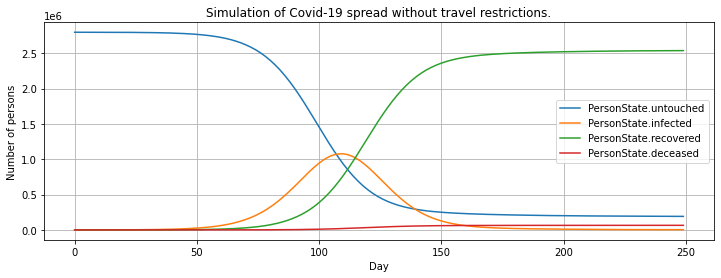

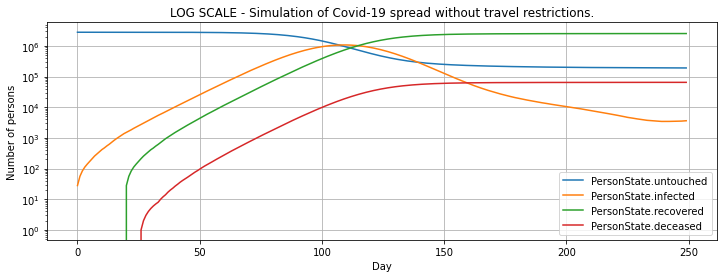

In [13]:
run(storage)


Population:      2,798,085
Deceased:                0 ( 0.0 %)
Peak infected:           0 ( 0.0 %)
Total affected:          0 ( 0.0 %)


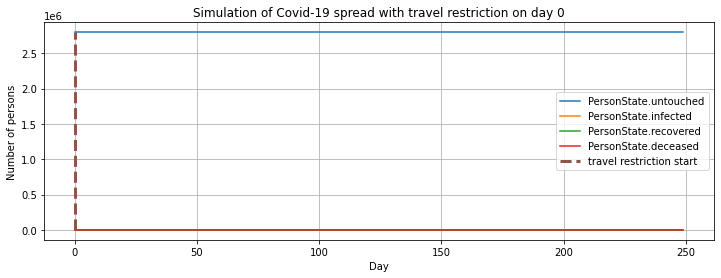

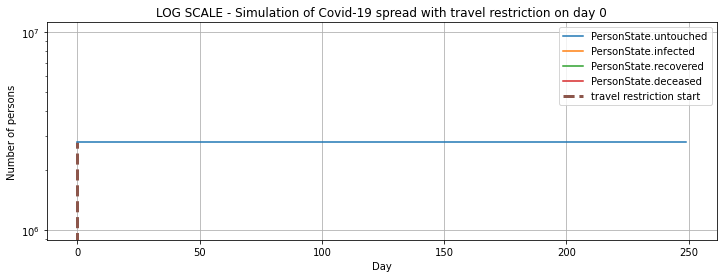

In [14]:
run(storage, travel_restriction_day=0)


Population:      2,798,085
Deceased:           32,954 ( 1.2 %)
Peak infected:     538,930 (19.3 %)
Total affected:  1,322,168 (47.3 %)


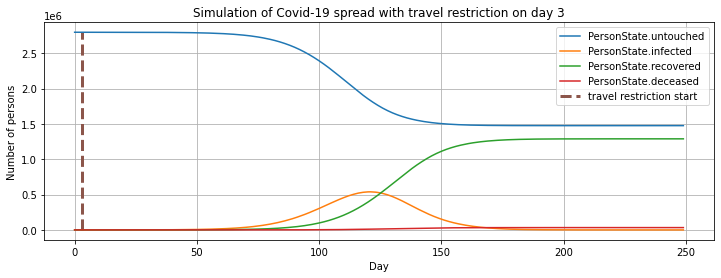

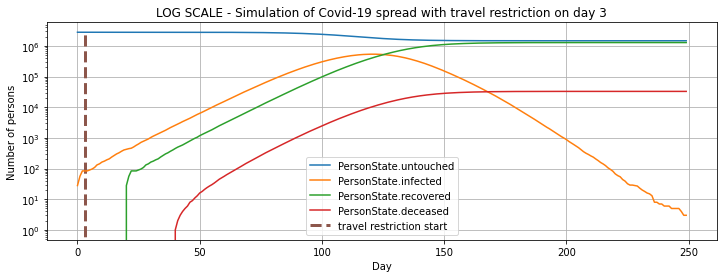

In [15]:
run(storage, travel_restriction_day=3)


Population:      2,798,085
Deceased:           50,565 ( 1.8 %)
Peak infected:     875,224 (31.3 %)
Total affected:  2,026,951 (72.4 %)


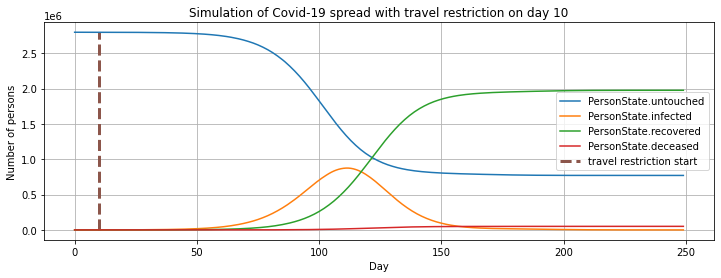

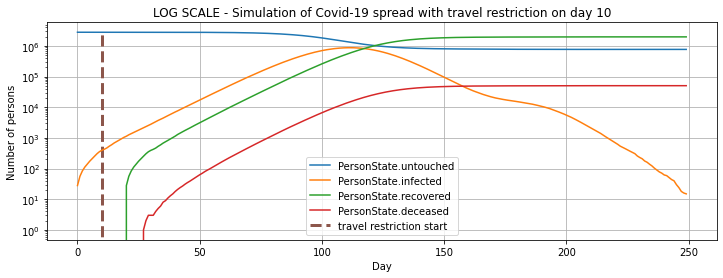

In [16]:
run(storage, travel_restriction_day=10)

The benefits of air travel restriction taper off quickly. It doesn't seem to help slow the virus down in a meaningful way if it has already taken hold in the country, unless it is done infeasibily early.

In fact, assuming that the number of true cases is 10x the number of reported cases, the Dutch government put the restriction in place around day 50:


Population:      2,798,085
Deceased:           63,343 ( 2.3 %)
Peak infected:   1,068,832 (38.2 %)
Total affected:  2,537,738 (90.7 %)


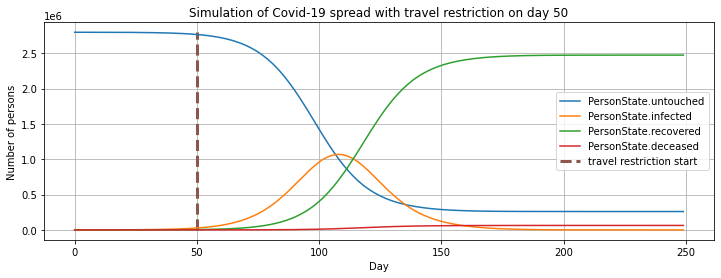

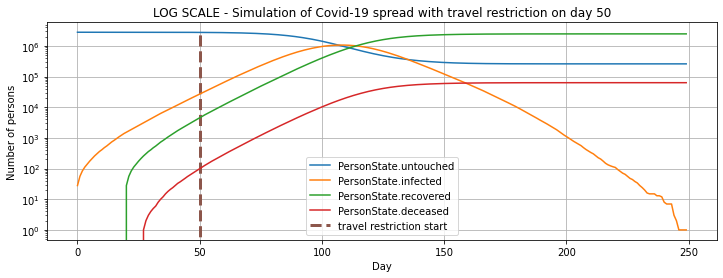

In [17]:
run(storage, travel_restriction_day=50)

Yes, that's definitely too late to have a meaningful impact on slowing it down.

### Social Distancing

Let's switch gears and look at the effect of social distancing, which was first called for around 1 to 1.5 weeks before the air travel restrictions came into place, let's say at day 40.


Population:      2,798,085
Deceased:           47,075 ( 1.7 %)
Peak infected:     400,128 (14.3 %)
Total affected:  1,926,207 (68.8 %)


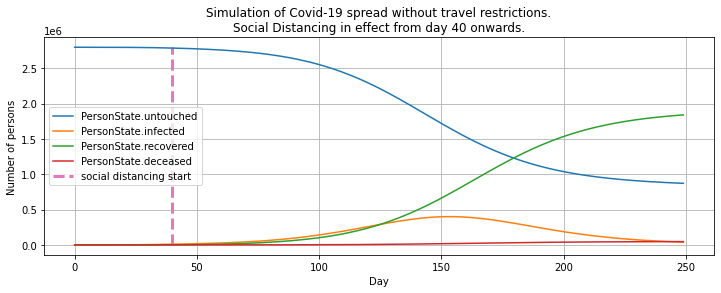

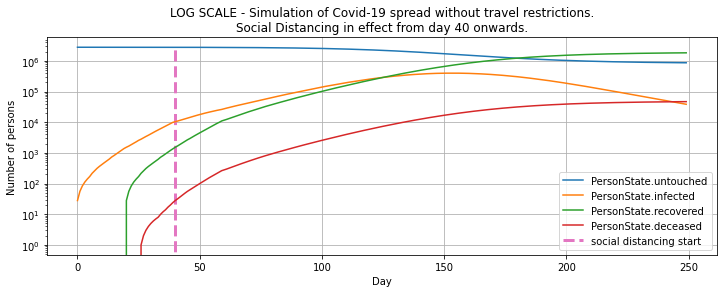

In [18]:
run(storage, social_distancing_day=40)

That's fantastic! Ok, what if we would have been a little later?


Population:      2,798,085
Deceased:           48,451 ( 1.7 %)
Peak infected:     417,743 (14.9 %)
Total affected:  1,965,775 (70.3 %)


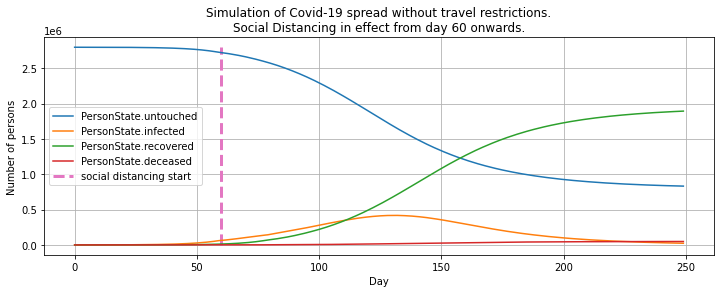

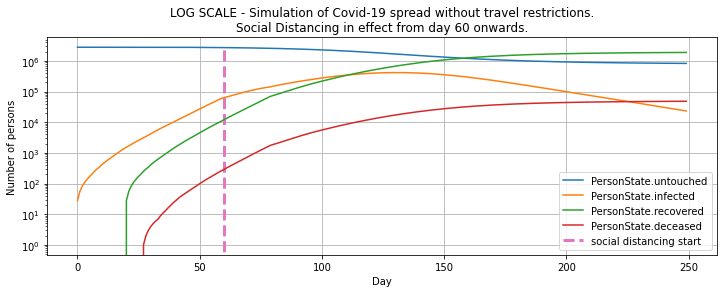

In [19]:
run(storage, social_distancing_day=60)

Still quite good.


Population:      2,798,085
Deceased:           50,733 ( 1.8 %)
Peak infected:     533,992 (19.1 %)
Total affected:  2,044,457 (73.1 %)


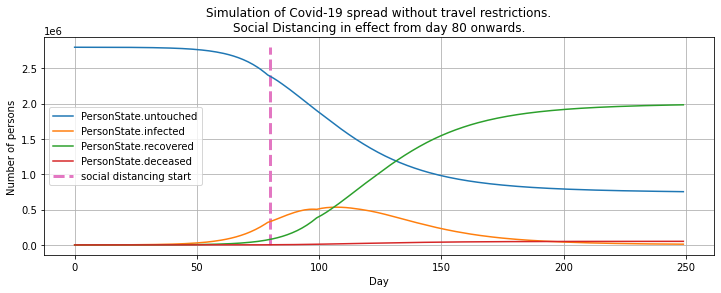

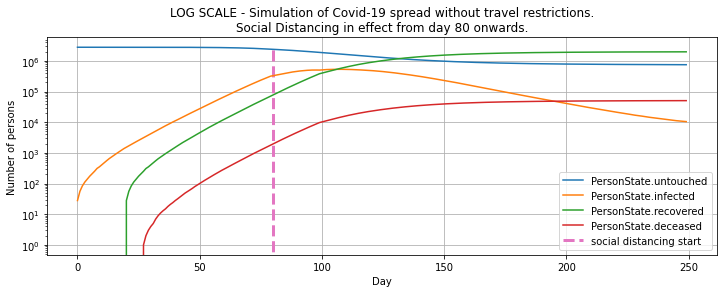

In [20]:
run(storage, social_distancing_day=80)

Even when applied as late as day 80, there remains a significant positive impact.

Overall, social distancing seems like a much more powerful tool when it comes to slowing down the virus.

### How about the combination?


Population:      2,798,085
Deceased:           45,845 ( 1.6 %)
Peak infected:     399,451 (14.3 %)
Total affected:  1,866,177 (66.7 %)


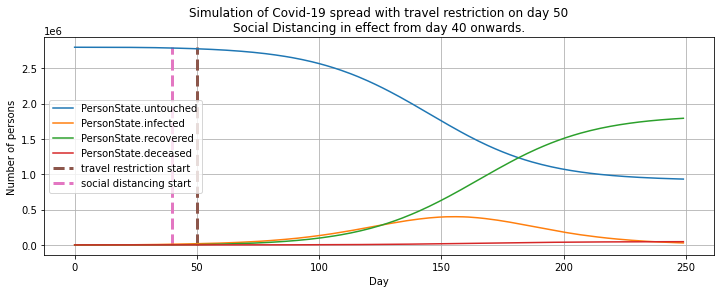

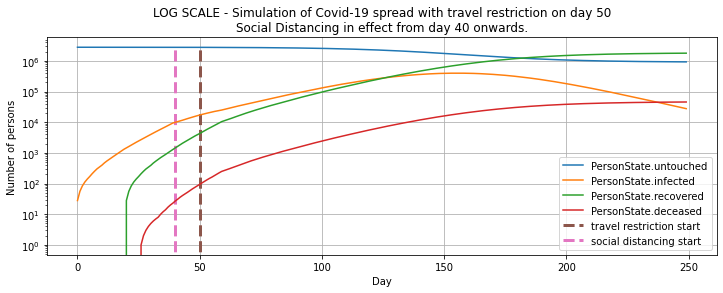

In [21]:
run(storage, social_distancing_day=40, travel_restriction_day=50)

This is slightly better than the scenario with *only* social distancing: all three percentages (deceased, peak infected, total affected) are down.

### Comparison

In [26]:
(
    pd.DataFrame([
        {
            "tr_day": sr.travel_restriction_day,
            "sd_day": sr.social_distancing_day,
            "perc_deceased": sr.perc_deceased,
            "perc_peak_infected": sr.perc_peak_infected,
            "perc_total_affected": sr.perc_total_affected,
        } for key, sr in storage.results.items()]
    )
    .set_index(["tr_day", "sd_day"])
    .query("tr_day != 0")
    .round(2)
    .sort_values(by="perc_peak_infected", ascending=False)
)

perc_deceased  perc_peak_infected  perc_total_affected
tr_day sd_day                                                        
NaN    NaN              2.32               38.50                93.16
50.0   NaN              2.26               38.20                90.70
10.0   NaN              1.81               31.28                72.44
3.0    NaN              1.18               19.26                47.25
NaN    80.0             1.81               19.08                73.07
       60.0             1.73               14.93                70.25
       40.0             1.68               14.30                68.84
50.0   40.0             1.64               14.28                66.69

The reason why we're seeing such a large difference between the effectiveness of the two measures, is that the spread of the virus is modeled as exponential, and social distancing puts a significant dampening effect on the exponential growth. On the other hand, incoming travelers are linear under the model's assumptions: the same number of infected travelers arrive every day. This is probably an oversimplification: it stands to reason that the number of infected travelers increases over time as well (up to some point).

Let's compare the plots for the best and the worst:

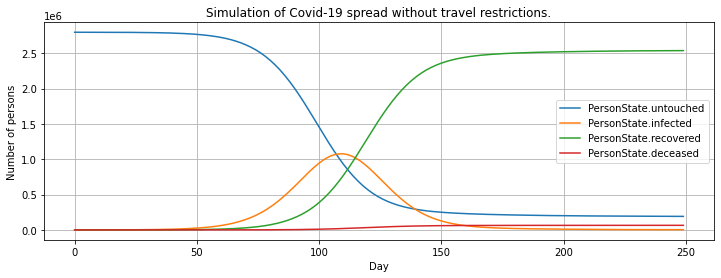

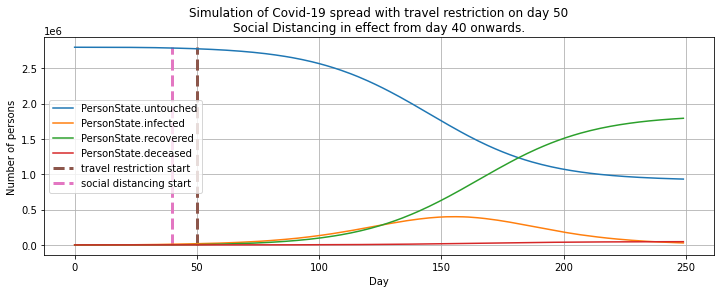

In [23]:
storage["SimulationResult(n_days=250, tr_day=None, sd_day=None)"].plot_count_curves()
storage["SimulationResult(n_days=250, tr_day=50, sd_day=40)"].plot_count_curves()

That's much better if you ask me!

In [ ]:
storage.save("./data/results/sim-30km/")

### Conclusion and next steps
In this limited and not-at-all realistic simulation, restricting air travel has only a minor effect on slowing down the virus. Unless it's done very, very early. Infeasibly early: which country is going to shut down air traffic if there's 30 true cases, which comes down to 3 confirmed / tested cases? Once the virus is out in the wild, measures such as social distancing appear to be much more effective at flattening the curve.

An important caveat to all this: simulations that involve exponential growth can be finnicky. Things may turn out very different with small changes to initial conditions or assumptions. If, say, the percentage of infected travelers is much higher, or increases over time, I'm sure the effect of restricting air travel would be more pronounced.

Well, this was informative! Next step for me is to use this rich geographic data to do some mapping with Kepler.gl. Stay tuned.
Code can be found here: [GitHub](https://github.com/jvanlier/blog-notebooks/tree/master/covid-19-simulation).